In [1]:
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import warnings
import optuna
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from utils import scale_data, inverse_transform, scatterplot, lineplot
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('Data/all_data.xlsx')
df.tail()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063
365,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,65496611844,positif,92,61198.382813


# PREPROCESSING

In [3]:
df = df.drop(columns=['Date', 'Volume', 'Sentimen', 'Index'])

In [4]:
X = df.drop('Close', axis=1)
y = df['Close']

In [5]:
X, y, scaler = scale_data(df)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
X_train = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])

In [8]:
print(X_train.shape)

(292, 4)


In [9]:
print(y_train.shape)

(292,)


# MODELING

In [10]:
def tuning(trial):
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-5, 1.0, log=True),  # L1 regularization
        "lambda": trial.suggest_float("lambda", 1e-5, 1.0, log=True),  # L2 regularization
    }

    model = XGBRegressor(**params, random_state=42)
    
    # Use cross-validation to evaluate the model
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    
    # Return the negative RMSE as Optuna minimizes the objective
    return -score.mean()

study = optuna.create_study(direction="minimize")
study.optimize(tuning, n_trials=50)

print('Best hyperparameters: ', study.best_params)
print('Best RMSE: ', study.best_value)

[I 2024-10-16 15:12:49,208] A new study created in memory with name: no-name-e2a0d943-2b64-4ac9-a932-2eaf8635740f
[I 2024-10-16 15:12:49,785] Trial 0 finished with value: 0.09028839233440392 and parameters: {'learning_rate': 0.006261517436651713, 'max_depth': 9, 'n_estimators': 64, 'subsample': 0.7999340484456214, 'colsample_bytree': 0.7023673992691355, 'alpha': 0.02181321466053053, 'lambda': 1.310654304721503e-05}. Best is trial 0 with value: 0.09028839233440392.
[I 2024-10-16 15:12:51,015] Trial 1 finished with value: 0.0566782781588339 and parameters: {'learning_rate': 0.03936846213180314, 'max_depth': 3, 'n_estimators': 364, 'subsample': 0.9405712924422359, 'colsample_bytree': 0.9174043090786932, 'alpha': 0.005499406462583306, 'lambda': 0.0011245257072973536}. Best is trial 1 with value: 0.0566782781588339.
[I 2024-10-16 15:12:51,327] Trial 2 finished with value: 0.056624671867231725 and parameters: {'learning_rate': 0.03567284190132466, 'max_depth': 1, 'n_estimators': 213, 'subsam

Best hyperparameters:  {'learning_rate': 0.040972650237876516, 'max_depth': 1, 'n_estimators': 430, 'subsample': 0.9967409331270196, 'colsample_bytree': 0.50443646723925, 'alpha': 1.618508283681588e-05, 'lambda': 0.4061220986358933}
Best RMSE:  0.055343781293071326


In [11]:
xgb = XGBRegressor(**study.best_params)
xgb.fit(X_train, y_train)

XGBRegressor(alpha=1.618508283681588e-05, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.50443646723925, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=0.4061220986358933, learning_rate=0.040972650237876516,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=430, n_jobs=None, ...)

In [12]:
xgb_pred_train = xgb.predict(X_train)

# Inverse transform
inverse_predictions_train = inverse_transform(scaler, xgb_pred_train)
y_train_original = inverse_transform(scaler=scaler, predictions=y_train)

compare_xgb_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
compare_xgb_train.head()

,Predicted,Actual
0,23534.174047,23475.466797
1,22501.265437,22362.679688
2,22501.265437,22353.349609
3,22501.265437,22435.513672
4,22501.265437,22429.757813


In [13]:
xgb_pred_test = xgb.predict(X_test)

# Inverse transform
inverse_predictions_test = inverse_transform(scaler, xgb_pred_test)
y_test_original = inverse_transform(scaler=scaler, predictions=y_test)

compare_xgb_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
compare_xgb_test.head()

,Predicted,Actual
0,42400.667630,42270.527344
1,42281.856164,43652.250000
2,43513.102539,43869.152344
3,43513.102539,43997.902344
4,43513.102539,43739.542969


# MATRIKS EVALUASI

In [14]:
mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
rmse_model_train = np.sqrt(mse_model_train)
rmse_model_test = np.sqrt(mse_model_test)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
print("======================================================")

# Menghitung R-squared
r2_xgb_train = r2_score(y_train, xgb_pred_train)
r2_xgb_test = r2_score(y_test, xgb_pred_test)
print("\nR-squared Train Set:", r2_xgb_train)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 499.3905827877357
Root Mean Squared Error (RMSE) Test Set: 5270.965129257151

R-squared Train Set: 0.9886743008152666
R-squared Test Set: -0.17933949200307953


In [15]:
scores = cross_val_score(xgb, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV score:", scores.mean())

Cross-validation scores: [ 0.481753    0.80533755  0.85717144  0.73669189 -4.77189573]
Mean CV score: -0.3781883670847577


# VISUALISASI

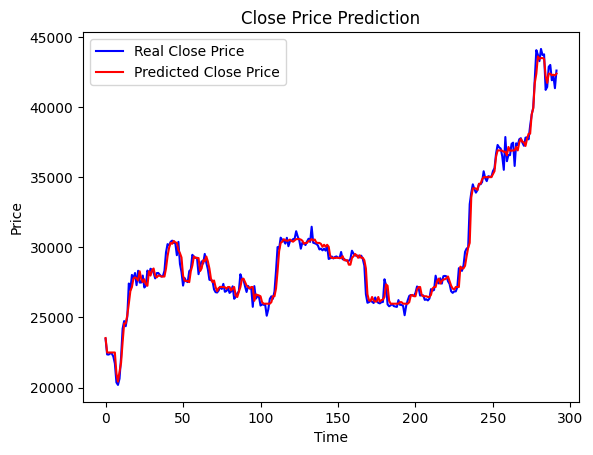

In [16]:
# lineplot train
lineplot(y_train_original, inverse_predictions_train)

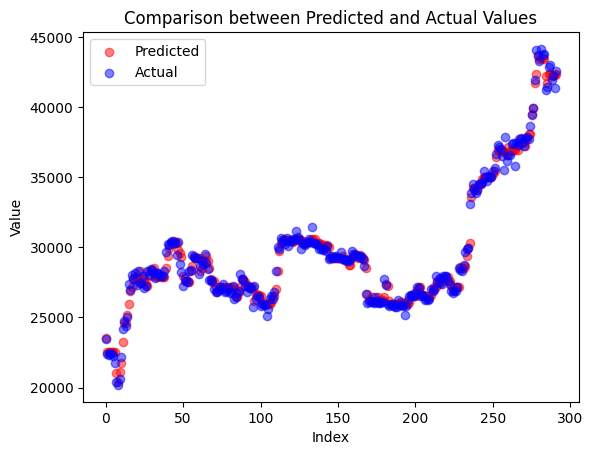

In [17]:
# scatterplot train
scatterplot(y_train_original, inverse_predictions_train)

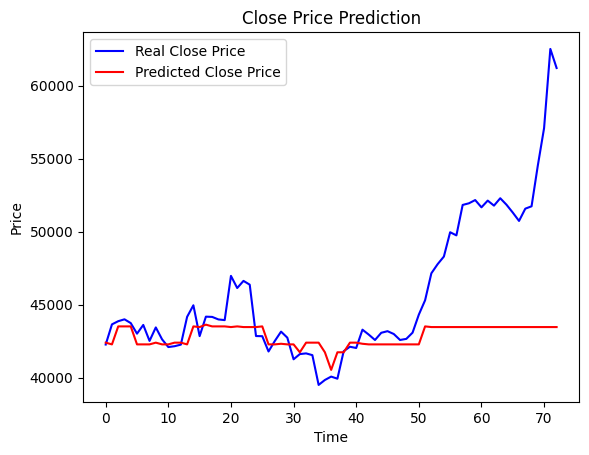

In [18]:
# lineplot test
lineplot(y_test_original, inverse_predictions_test)

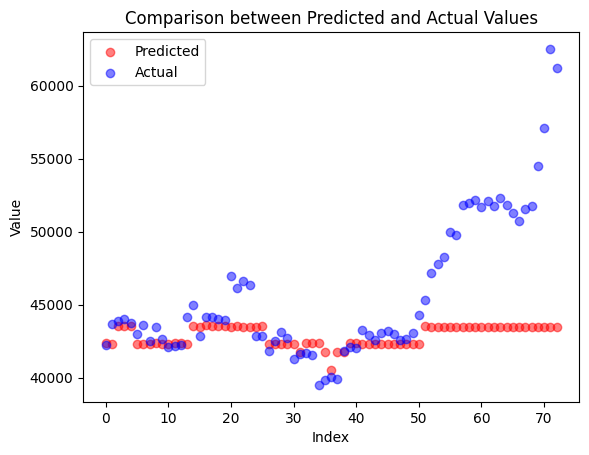

In [19]:
# scatterplot test
scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [20]:
df.columns

Index(['Open', 'High', 'Low', 'Adj_Close', 'Close'], dtype='object')

In [21]:
feature_names = ['Open', 'High', 'Low', 'Adj_Close']

In [22]:
X_train

array([[0.07002981, 0.08061168, 0.08466681, 0.08174639],
       [0.08175457, 0.07736212, 0.0884934 , 0.07770353],
       [0.07772759, 0.07139575, 0.06324821, 0.05140741],
       ...,
       [0.53981725, 0.52172496, 0.53986928, 0.51379431],
       [0.51404381, 0.5120131 , 0.54060684, 0.52112837],
       [0.52109552, 0.50499814, 0.52963143, 0.50044066]])

In [23]:
shap.initjs()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)
i = 100

# Jika X_train adalah array NumPy, akses baris ke-30 menggunakan indeks array biasa
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[30], feature_names=feature_names)

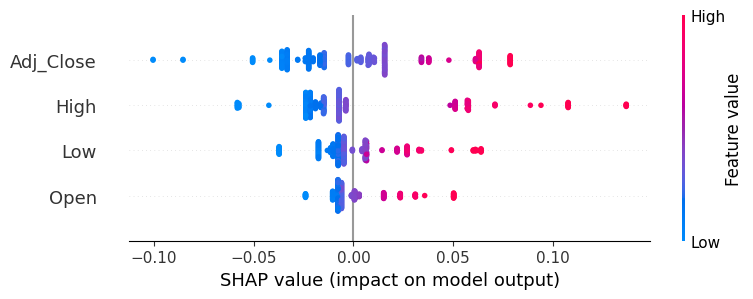

In [24]:
shap.summary_plot(shap_values, features=X_train, feature_names=feature_names)

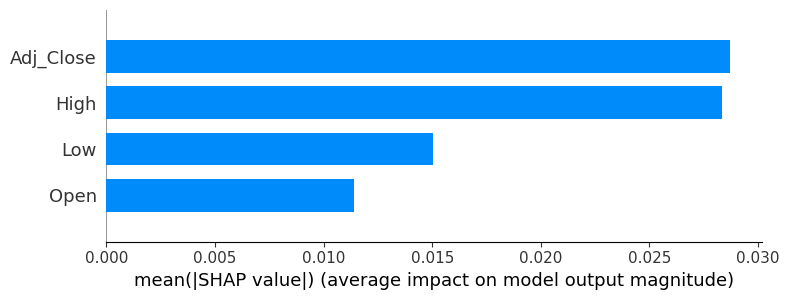

In [25]:
shap.summary_plot(shap_values, features=X_train, feature_names=feature_names, plot_type="bar")

# TEST DENGAN DATA BARU

In [26]:
dt = pd.read_excel('all_data_validation.xlsx')
dt = dt.drop(columns=["Date", "Volume", "Sentimen", "Index"])

In [27]:
X_ = dt.drop(columns=['Close'])
y_ = dt['Close']

In [28]:
X_, y_, scalers = scale_data(dt)

In [29]:
X_ = X_.reshape(X_.shape[0] * X_.shape[1], X_.shape[2])

In [30]:
xgb_pred_new = xgb.predict(X_)

# Inverse transform
inverse_predictions_new = inverse_transform(scaler, predictions=xgb_pred_new)
y_test_original_new = inverse_transform(scaler=scaler, predictions=y_)

compare_xgb_train = pd.DataFrame({'Predicted': inverse_predictions_new, 'Actual': y_test_original_new})
compare_xgb_train.head()

,Predicted,Actual
0,24037.198879,20630.750967
1,22250.644662,24939.978206
2,24373.251023,44498.894232
3,37492.777170,27341.079872
4,35172.124689,36075.298051


In [31]:
mse_xgb_new = mean_squared_error(y_, xgb_pred_new)
rmse_xgb_new = np.sqrt(mse_xgb_new)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_xgb_new)
print("======================================================")

# Menghitung R-squared
r2_xgb_new = r2_score(y_, xgb_pred_new)
print("\nR-squared Train Set:", r2_xgb_new)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 0.24302983734564068

R-squared Train Set: 0.18277004531874008


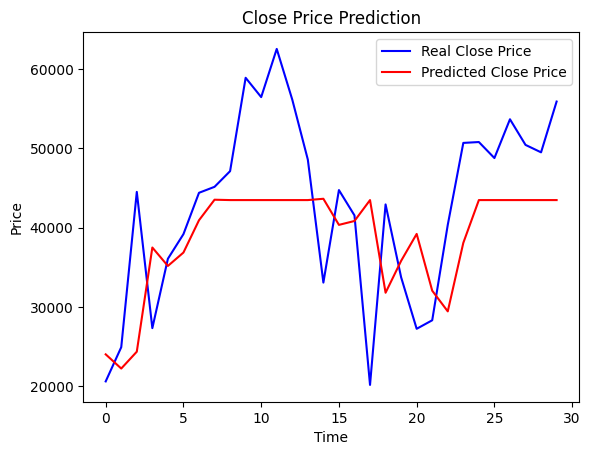

In [32]:
lineplot(y_test_original_new, inverse_predictions_new)

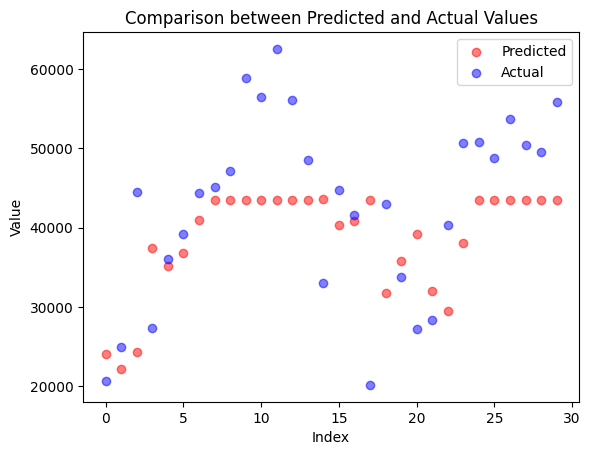

In [33]:
scatterplot(y_test_original_new, inverse_predictions_new)